# Direct Access - ECCO netCDF example

### Getting Started

In this notebook, we will access monthly sea surface height from ECCO V4r4 (10.5067/ECG5D-SSH44). The data are provided as a time series of monthly netCDFs on a 0.5-degree latitude/longitude grid.

We will access the data from inside the AWS cloud (us-west-2 region, specifically) and load a time series made of multiple netCDF datasets into a single xarray dataset. This approach leverages S3 native protocols for efficient access to the data.

### Requirements
#### AWS

This notebook should be running in an EC2 instance in AWS region us-west-2, as previously mentioned. We recommend using an EC2 with at least 8GB of memory available.

The notebook was developed and tested using a t2.small instance (_ CPUs; 8GB memory).
Python 3

Most of these imports are from the Python standard library. However, you will need to install these packages into your Python 3 environment if you have not already done so:

- s3fs
- requests
- pandas
- xarray
- matplotlib
- cartopy

### Learning Objectives

- import needed libraries
- define dataset of interest
- authenticate for NASA Earthdata archive (Earthdata Login)
- obtain AWS credentials for Earthdata DAAC archive in AWS S3
- **access DAAC data directly from the in-region S3 bucket without moving or downloading any files to your local (cloud) workspace**
- plot the first time step in the data

In [2]:
import os
import subprocess
from os.path import dirname, join

# Access EDS
import requests

# Access AWS S3
import boto3
import s3fs

# Read and work with datasets
import pandas as pd
import numpy as np
import xarray as xr

# Plotting
import matplotlib.pyplot as plt
import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeat

#### Define dataset of interest

In this case it's the following string that unique identifies the collection of monthly, 0.5-degree sea surface height data.

In [3]:
ShortName = "ECCO_L4_SSH_05DEG_MONTHLY_V4R4"

### Earthdata login

You should have a .netrc file set up like:

`machine urs.earthdata.nasa.gov login <username> password <password>`

See the following (Authentication for NASA Earthdata tutorial)[https://nasa-openscapes.github.io/2021-Cloud-Hackathon/tutorials/04_NASA_Earthdata_Authentication.html]

### AWS credentials to Access Data from S3

Pass credentials and configuration to AWS so we can interact with S3 objects from applicable buckets. For now, each DAAC has different AWS credentials endpoints. LP DAAC and PO.DAAC are listed here:

In [5]:
s3_cred_endpoint = {
    'podaac':'https://archive.podaac.earthdata.nasa.gov/s3credentials',
    'lpdaac':'https://data.lpdaac.earthdatacloud.nasa.gov/s3credentials'
}

In this example we're interested in the ECCO data collection from PO.DAAC in Earthdata Cloud in AWS S3, so we specify the podaac endpoint in the next code block.

Set up an s3fs session for authneticated access to ECCO netCDF files in s3:

In [6]:
def begin_s3_direct_access(url: str=s3_cred_endpoint['podaac']):
    response = requests.get(url).json()
    return s3fs.S3FileSystem(key=response['accessKeyId'],
                             secret=response['secretAccessKey'],
                             token=response['sessionToken'],
                             client_kwargs={'region_name':'us-west-2'})

fs = begin_s3_direct_access()

Get a list of netCDF files located at the S3 path corresponding to the ECCO V4r4 monthly sea surface height dataset on the 0.5-degree latitude/longitude grid, for year 2015.

In [7]:
ssh_Files = fs.glob(join("podaac-ops-cumulus-protected/", ShortName, "*2015*.nc"))

len(ssh_Files)

12

#### Access in-region S3 cloud data without moving files

Now that we have authenticated in AWS, this next code block *accesses* data directly from the NASA Earthdata archive in an S3 bucket in `us-west-2` region, without downloading or moving any files into your user cloud workspace (instnace).

Open with the netCDF files using the s3fs package, then load them all at once into a concatenated xarray dataset.

In [8]:
ssh_Dataset = xr.open_mfdataset(
    paths=[fs.open(f) for f in ssh_Files],
    combine='by_coords',
    mask_and_scale=True,
    decode_cf=True,
    chunks={'latitude': 60,   # These were chosen arbitrarily. You must specify 
            'longitude': 120, # chunking that is suitable to the data and target
            'time': 100}      # analysis.
)

ssh = ssh_Dataset.SSH

print(ssh)

<xarray.DataArray 'SSH' (time: 12, latitude: 360, longitude: 720)>
dask.array<concatenate, shape=(12, 360, 720), dtype=float32, chunksize=(1, 60, 120), chunktype=numpy.ndarray>
Coordinates:
  * time       (time) datetime64[ns] 2015-01-16T12:00:00 ... 2015-12-16T12:00:00
  * latitude   (latitude) float32 -89.75 -89.25 -88.75 ... 88.75 89.25 89.75
  * longitude  (longitude) float32 -179.8 -179.2 -178.8 ... 178.8 179.2 179.8
Attributes:
    coverage_content_type:  modelResult
    long_name:              Dynamic sea surface height anomaly
    standard_name:          sea_surface_height_above_geoid
    units:                  m
    comment:                Dynamic sea surface height anomaly above the geoi...
    valid_min:              [-1.88057721]
    valid_max:              [1.42077196]


### Plot the gridded sea surface height time series

But only the timesteps beginning in 2015:


In [9]:
ssh_after_201x = ssh[ssh['time.year']>=2015,:,:]

print(ssh_after_201x)

<xarray.DataArray 'SSH' (time: 12, latitude: 360, longitude: 720)>
dask.array<concatenate, shape=(12, 360, 720), dtype=float32, chunksize=(1, 60, 120), chunktype=numpy.ndarray>
Coordinates:
  * time       (time) datetime64[ns] 2015-01-16T12:00:00 ... 2015-12-16T12:00:00
  * latitude   (latitude) float32 -89.75 -89.25 -88.75 ... 88.75 89.25 89.75
  * longitude  (longitude) float32 -179.8 -179.2 -178.8 ... 178.8 179.2 179.8
Attributes:
    coverage_content_type:  modelResult
    long_name:              Dynamic sea surface height anomaly
    standard_name:          sea_surface_height_above_geoid
    units:                  m
    comment:                Dynamic sea surface height anomaly above the geoi...
    valid_min:              [-1.88057721]
    valid_max:              [1.42077196]


Plot the grid for the first time step using a Robinson projection. Define a helper function for consistency throughout the notebook:

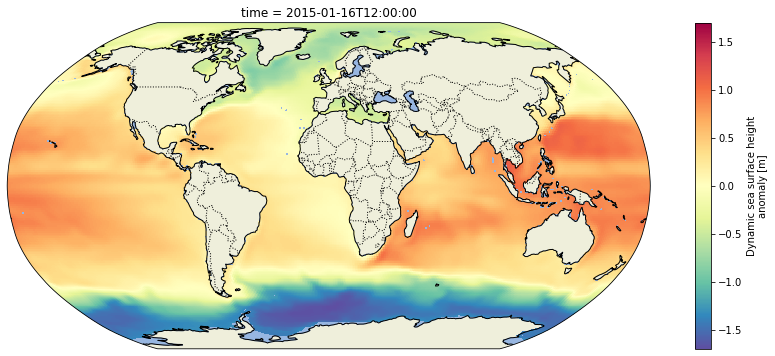

In [10]:
def make_figure(proj):
    fig = plt.figure(figsize=(16,6))
    ax = fig.add_subplot(1, 1, 1, projection=proj)
    ax.add_feature(cfeat.LAND)
    ax.add_feature(cfeat.OCEAN)
    ax.add_feature(cfeat.COASTLINE)
    ax.add_feature(cfeat.BORDERS, linestyle='dotted')
    return fig, ax

fig, ax = make_figure(proj=ccrs.Robinson())

ssh_after_201x.isel(time=0).plot(ax=ax, transform=ccrs.PlateCarree(), cmap='Spectral_r')

### Additional Resources 

- Full example with additional plots and use cases here: https://github.com/podaac/ECCO/blob/main/Data_Access/cloud_direct_access_s3.ipynb